# Assignment: Linear Models
## Do two questions in total: "Q1+Q2" or "Q1+Q3"
### `! git clone https://github.com/ds3001f25/linear_models_assignment.git`

**Q1.** Let's explore multiple linear regression in a two-variable case, to build more intuition about what is happening.

Suppose the model is
$$
\hat{y}_i = b_0 + b_1 z_{i1} + b_2 z_{i2}
$$
Assume that $z_{ij}$ is centered or de-meaned, so that $z_{ij} = x_{ij} - m_j$ where $m_j$ is the mean of variable $j$ and $x_{ij}$ is the original value of variable $j$ for observation $i$. Notice that this implies
$$
\dfrac{1}{N} \sum_{i=1}^N z_{ij} = 0
$$
which will simplify your calculations below substantially!

1. Write down the SSE for this model.
2. Take partial derivatives with respect to $b_0$, $b_1$, and $b_2$.
3. Verify that the average error is zero and $e \cdot z =0$ at the optimum, just as in the single linear regression case.
4. Show that the optimal intercept is $b_0^* = \bar{y}$. Eliminate $b_0^*$ from the remaining equations, and focus on $b_1$ and $b_2$.
5. Write your results as a matrix equation in the form "$Ab=C$". These are called the **normal equations**.
6. Divide both sides by $N$ and substitute $z_{ij} = x_{ij} - m_j$ back into your normal equations for $x_{ij}$. What is the matrix $A$? What is the vector $C$? Explain the intuition of your discovery.

Uploaded to GitHub in separate file.

**Q2.** This question is a case study for linear models. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.
  2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?
  3. Split the data into an 80% training set and a 20% testing set.
  4. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the training set and test set? Make a second model where, for the categorical variables, you regress price on a model comprised of one-hot encoded regressors/features alone (you can use `pd.get_dummies()`; be careful of the dummy variable trap); what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?
  5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using in the regression. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 4?
  6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.

**Q3.** This question refers to the `heart_hw.csv` data. It contains three variables:

  - `y`: Whether the individual survived for three years, coded 0 for death and 1 for survival
  - `age`: Patient's age
  - `transplant`: `control` for not receiving a transplant and `treatment` for receiving a transplant

Since a heart transplant is a dangerous operation and even people who successfully get heart transplants might suffer later complications, we want to look at whether a group of transplant recipients tends to survive longer than a comparison group who does not get the procedure.

1. Compute (a) the proportion of people who survive in the control group who do not receive a transplant, and (b) the difference between the proportion of people who survive in the treatment group and the proportion of people who survive in the control group. In a randomized controlled trial, this is called the **average treatment effect**.
2. Regress `y` on `transplant` using a linear model with a constant. How does the constant/intercept of the regression and the coefficient on transplant compare to your answers from part 1? Explain the relationship clearly.
3. We'd like to include `age` in the regression, since it's reasonable to expect that older patients are less likely to survive an extensive surgery like a heart transplant. Regress `y` on a constant, transplant, and age. How does the intercept change?
4. Build a more flexible model that allows for non-linear age effects and interactions between age and treatment. Use a train-test split to validate your model. Estimate your best model, predict the survival probability by age, and plot your results conditional on receiving a transplant and not. Describe what you see.
5. Imagine someone suggests using these kinds of models to select who receives organ transplants; perhaps the CDC or NIH starts using a scoring algorithm to decide who is contacted about a potential organ. What are your concerns about how it is built and how it is deployed?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
heart = pd.read_csv('heart_hw.csv')
heart['transplant'].unique()
heart.head()

,Unnamed: 0,age,transplant,y
0,1,53,control,0
1,2,43,control,0
2,3,52,control,0
3,4,52,control,0
4,5,54,control,0


In [3]:
no_transplant = heart[heart['transplant'] == 'control']
survive_no_transplant = no_transplant[no_transplant['y'] == 1]
proportion_no_transplant = len(survive_no_transplant) / len(no_transplant)
print("The proportion of people who survived with no transplant is:")
print(proportion_no_transplant)

The proportion of people who survived with no transplant is:
0.11764705882352941


In [4]:
treatment = heart[heart['transplant'] == 'treatment']
survive_treatment = treatment[treatment['y'] == 1]
proportion_treatment = len(survive_treatment) / len(treatment)
difference = proportion_treatment - proportion_no_transplant
print("The difference between survival in treatment and control is:")
print(difference)

The difference between survival in treatment and control is:
0.23017902813299232


In [5]:


heart['transplant'] = heart['transplant'].map({'control': 0, 'treatment': 1})
heart['transplant'].unique()


array([0, 1])

In [6]:
x = heart['transplant'].astype(int)
y = heart['y']

def slr(x,y):
    x_bar = np.mean(x)
    y_bar = np.mean(y)
    b1 = np.inner(x-x_bar,y-y_bar)/np.inner(x-x_bar,x-x_bar)
    b0 = y_bar - b1*x_bar
    y_hat = b0 + b1*x
    residuals = y - y_hat
    return({'b0':b0,'b1':b1,'y_hat':y_hat,'residuals':residuals})

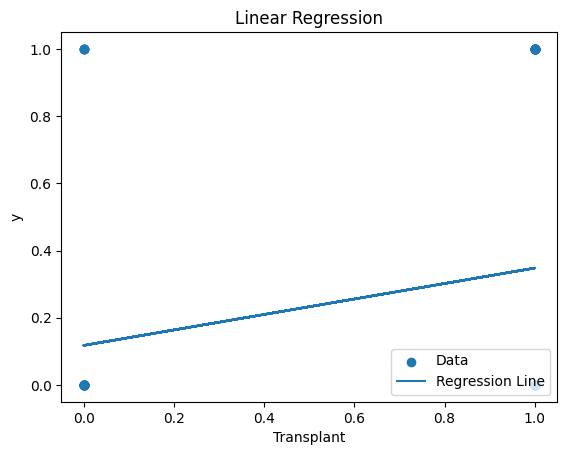

In [7]:
reg = slr(x,y)

plt.scatter(x,y,label='Data')
plt.plot(x,reg['y_hat'],label='Regression Line')
plt.xlabel("Transplant")
plt.ylabel("y")
plt.legend(loc='lower right')
plt.title('Linear Regression')
plt.show()

In [8]:
b0, b1 = reg['b0'], reg['b1']
print("The intercept is:")
print(b0)
print("The coefficient is:")
print(b1)

The intercept is:
0.11764705882352941
The coefficient is:
0.23017902813299232


The intercept is the same as the average control survival rate calculated in part 1 and the coefficient on the transplant is equal to the difference in survival rate between the treatment and control groups.

In [9]:
y = heart['y']
x1 = heart['transplant']
x2 = heart['age']

reg1_y = slr(x1,y)
reg1_2 = slr(x1,x2)
y_temp = reg1_y['residuals']
x2_temp = reg1_2['residuals']
reg_y_x2 = slr(x2_temp,y_temp)
print('Age coefficient: ', reg_y_x2['b1'])

reg2_y = slr(x2,y)
reg2_1 = slr(x2,x1)
y_resid = reg2_y['residuals']
x1_resid = reg2_1['residuals']
reg_y_x1 = slr(x1_resid,y_resid)
print('Transplant coefficient: ', reg_y_x1['b1'])

b0 = np.mean(y) - reg_y_x1['b1'] * np.mean(x1) - reg_y_x2['b1']*np.mean(x2)
print('Intercept: ', b0, '\n')


Age coefficient:  -0.013607217160218649
Transplant coefficient:  0.26470168650367504
Intercept:  0.7019569721740948 



The intercept increases from around 0.118 to 0.702.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

y = heart['y']
vars = ['transplant','age']

X = heart.loc[:, vars]
X.head()

,transplant,age
0,0,53
1,0,43
2,0,52
3,0,52
4,0,54


In [12]:
reg = LinearRegression().fit(X, y)
print('Intercept: ', reg.intercept_)
print('Coefficients: ', reg.coef_)
print('R squared: ', reg.score(X, y))

Intercept:  0.7019569721740947
Coefficients:  [ 0.26470169 -0.01360722]
R squared:  0.1467806594163431
